In [1]:
!module load tensorflow
!hostname
#Based on: https://chroniclesofai.com/transfer-learning-with-keras-resnet-50/
#and https://github.com/nachi-hebbar/Transfer-Learning-ResNet-Keras/blob/main/ResNet_50.ipynb
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

tensorflow/2.5.0-cuda-system unloaded
tensorflow/2.5.0-cuda-system loaded
c210-6


In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)
img_height,img_width=180,180
batch_size=32

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
print(physical_devices)
tf.config.set_visible_devices(physical_devices[0:1],'GPU') 
strategy = tf.distribute.MultiWorkerMirroredStrategy()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:GPU:0',), communication = CommunicationImplementation.AUTO


In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size*2) #Double the batch size for 2 GPUs

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size*2) #double the batch size for 2 GPUs


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


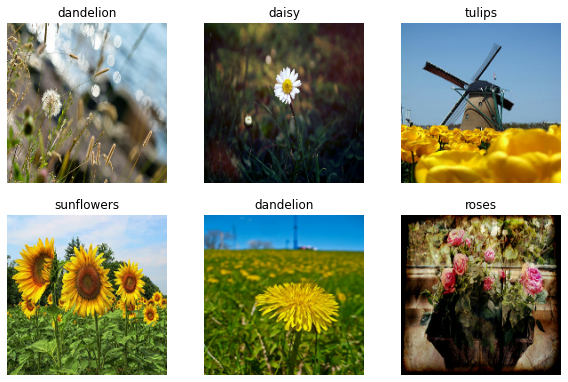

In [5]:
import matplotlib.pyplot as plt
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
#BATCH_SIZE_PER_REPLICA = 32
#GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
#train_batches = train_ds.batch(GLOBAL_BATCH_SIZE)
#val_batches = val_ds.batch(GLOBAL_BATCH_SIZE)

with strategy.scope():   
    resnet_model = Sequential()
    pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(180,180,3),
                   pooling='avg',classes=5,
                   weights='imagenet')
    for layer in pretrained_model.layers:
        layer.trainable=False
    resnet_model.add(pretrained_model)
    resnet_model.add(Flatten())
    resnet_model.add(Dense(512, activation='relu'))
    resnet_model.add(Dense(5, activation='softmax'))
    resnet_model.summary()    
    resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

#history = resnet_model.fit(train_batches, validation_data=val_batches, epochs=10)
history = resnet_model.fit(train_ds,validation_data=val_ds, epochs=10)



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 24,639,365
Trainable params: 1,051,653
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/10
46/46 [==============================] - 16s 188ms/step - loss: 0.7880 - accuracy: 0.7493 - val_loss: 0.4232 - val_accuracy: 0.8447
Epoch 2/10
46/46 [==============================] - 7s 126ms/step - loss: 0.2598 - accuracy

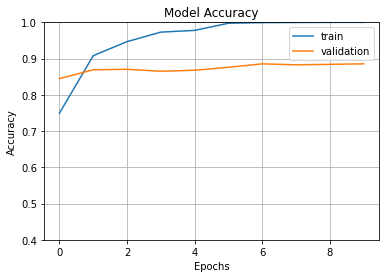

In [7]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()